In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

META_PATH = "../data/processed/covid_misinfo_metadata_features.csv"
TEXT_PATH = "../data_text/processed/isot_text_processed.csv"


In [3]:
meta_df = pd.read_csv(META_PATH)
text_df = pd.read_csv(TEXT_PATH)

print("Meta shape:", meta_df.shape)
print("Text shape:", text_df.shape)

print("\nMeta columns:", meta_df.columns.tolist())
print("\nText columns:", text_df.columns.tolist())

print("\nMeta label counts:\n", meta_df["label"].value_counts())
print("\nText label counts:\n", text_df["label"].value_counts())


Meta shape: (195843, 20)
Text shape: (44889, 2)

Meta columns: ['id', 'graph_id', 'label', 'time', 'friends', 'followers', 'log_followers', 'log_friends', 'followers_per_friend', 'friends_per_follower', 'followers_x_friends', 'time_bin_(105334.4, 192032.4]', 'time_bin_(12422.8, 29139.0]', 'time_bin_(1812591.4, 244196420.0]', 'time_bin_(192032.4, 452590.0]', 'time_bin_(2782.2, 12422.8]', 'time_bin_(29139.0, 49633.8]', 'time_bin_(452590.0, 1812591.4]', 'time_bin_(49633.8, 72728.0]', 'time_bin_(72728.0, 105334.4]']

Text columns: ['clean_text', 'label']

Meta label counts:
 label
0    157146
1     38697
Name: count, dtype: int64

Text label counts:
 label
1    23472
0    21417
Name: count, dtype: int64


In [4]:
import numpy as np
import pandas as pd

# Work ONLY with text_df for Hybrid v0
df = text_df.copy()

# Basic text-derived structural features
df["n_chars"] = df["clean_text"].str.len()
df["n_words"] = df["clean_text"].str.split().str.len()
df["avg_word_len"] = df["n_chars"] / df["n_words"].replace(0, np.nan)
df["avg_word_len"] = df["avg_word_len"].fillna(0)

# Optional but helpful: how “shouty” / punctuated the text is (works even after cleaning)
# If your clean_text removed punctuation, these will mostly be 0. That's fine.
df["n_exclam"] = df["clean_text"].str.count("!")
df["n_qmark"]  = df["clean_text"].str.count(r"\?")
df["pct_caps"] = 0.0  # clean_text is lowercased, so caps info is gone

y = df["label"].astype(int).values
X_text = df["clean_text"].astype(str).values

numeric_feats = ["n_chars", "n_words", "avg_word_len", "n_exclam", "n_qmark", "pct_caps"]
X_num = df[numeric_feats].values

df[numeric_feats].describe()


,n_chars,n_words,avg_word_len,n_exclam,n_qmark,pct_caps
count,44889.000000,44889.000000,44889.000000,44889.0,44889.0,44889.0
mean,2465.006817,423.322106,5.833850,0.0,0.0,0.0
std,2102.465369,357.119377,0.306062,0.0,0.0,0.0
min,22.000000,3.000000,4.300000,0.0,0.0,0.0
25%,1270.000000,218.000000,5.638142,0.0,0.0,0.0
50%,2195.000000,380.000000,5.840000,0.0,0.0,0.0
75%,3082.000000,533.000000,6.026549,0.0,0.0,0.0
max,50420.000000,8295.000000,8.125000,0.0,0.0,0.0


In [5]:
from sklearn.model_selection import train_test_split

X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_text, X_num, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(y_train), "Test size:", len(y_test))
print("Train label counts:", np.bincount(y_train))
print("Test label counts:", np.bincount(y_test))


Train size: 35911 Test size: 8978
Train label counts: [17134 18777]
Test label counts: [4283 4695]


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=50000,
    ngram_range=(1, 2)
)

X_tfidf_train = tfidf.fit_transform(X_text_train)
X_tfidf_test  = tfidf.transform(X_text_test)

scaler = StandardScaler(with_mean=False)  # keep sparse-friendly behavior
X_num_train_scaled = scaler.fit_transform(X_num_train)
X_num_test_scaled  = scaler.transform(X_num_test)

# Convert numeric to sparse and stack with tfidf
X_train = hstack([X_tfidf_train, csr_matrix(X_num_train_scaled)])
X_test  = hstack([X_tfidf_test,  csr_matrix(X_num_test_scaled)])

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (35911, 50006)
X_test shape: (8978, 50006)


In [7]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=3000)
model.fit(X_train, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9884161283136556
              precision    recall  f1-score   support

           0      0.986     0.990     0.988      4283
           1      0.991     0.987     0.989      4695

    accuracy                          0.988      8978
   macro avg      0.988     0.988     0.988      8978
weighted avg      0.988     0.988     0.988      8978

Confusion matrix:
 [[4240   43]
 [  61 4634]]


In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_proba = model.predict_proba(X_test)[:, 1]

def eval_threshold(thresh: float):
    y_pred_t = (y_proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    return {
        "threshold": thresh,
        "accuracy": accuracy_score(y_test, y_pred_t),
        "precision": precision_score(y_test, y_pred_t, zero_division=0),
        "recall": recall_score(y_test, y_pred_t, zero_division=0),
        "f1": f1_score(y_test, y_pred_t, zero_division=0),
        "TP": tp, "FP": fp, "TN": tn, "FN": fn
    }

thresholds = np.round(np.arange(0.1, 1.0, 0.1), 1)
results = pd.DataFrame([eval_threshold(t) for t in thresholds])
results


,threshold,accuracy,precision,recall,f1,TP,FP,TN,FN
0,0.1,0.904433,0.845863,0.999361,0.916227,4692,855,3428,3
1,0.2,0.962464,0.934757,0.997870,0.965283,4685,327,3956,10
2,0.3,0.981622,0.968944,0.996805,0.982677,4680,150,4133,15
3,0.4,0.986523,0.981271,0.993184,0.987192,4663,89,4194,32
4,0.5,0.988416,0.990806,0.987007,0.988903,4634,43,4240,61
5,0.6,0.985854,0.995660,0.977210,0.986348,4588,20,4263,107
6,0.7,0.977055,0.997562,0.958466,0.977623,4500,11,4272,195
7,0.8,0.956338,0.998379,0.917998,0.956502,4310,7,4276,385
8,0.9,0.904544,1.000000,0.817465,0.899566,3838,0,4283,857


In [11]:
import os
os.makedirs("../outputs/hybrid_v0", exist_ok=True)
results.to_csv("../outputs/hybrid_v0/threshold_results.csv", index=False)


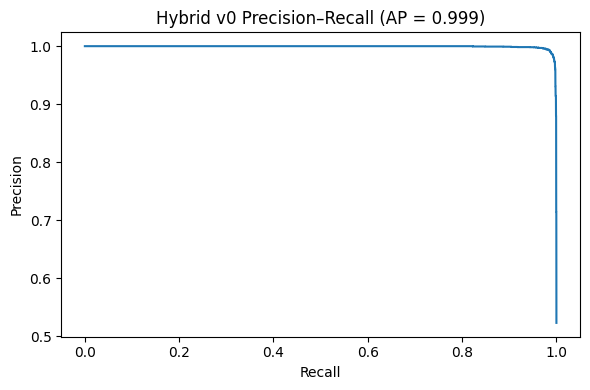

Average Precision (AP): 0.9992326563592906


In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

os.makedirs("../outputs/hybrid_v0", exist_ok=True)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Hybrid v0 Precision–Recall (AP = {ap:.3f})")
plt.tight_layout()
plt.savefig("../outputs/hybrid_v0/pr_curve.png", dpi=200)
plt.show()

print("Average Precision (AP):", ap)


Conclusion:

This notebook trains a hybrid classifier that combines TF-IDF text features with structural features computed from the text (e.g., length and word statistics). Results are evaluated using a classification report, threshold table, and a precision recall curve. This hybrid volume 0 model tests whether simple “metadata-like” signals improve performance beyond a pure text model, while keeping the experiment within a single dataset. A future hybrid volume 1 model will require a dataset that contains both real platform metadata and text for the same posts.
